In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy import special
from scipy import signal
from scipy import linalg
from tqdm.notebook import tqdm
from ArrayScript import RealArray
import pickle

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
Nside = 10
Nant = Nside**2
dlen = int((Nant**2 - Nant)/2)
M = 14
m = 1
beam_rad = .4
airy_fact = 3.83
array_shape = (Nside, Nside)

In [4]:
airy = lambda x: 4 * (special.j1(x)/x)**2

In [1313]:
geom_error = 0.00001
phase_error = 0.05
gpos = np.random.normal(0, geom_error, (Nant, 2))
ppos = np.random.normal(0, phase_error, (Nant, 2))
# ppos = np.zeros((Nant, 2))
# gpos = np.zeros((Nant, 2))
beam_comp_phase = np.exp(1j*np.random.uniform(0, 2*np.pi,Nant))
# beam_comp_phase = np.ones(Nant)

phase_correction = [np.exp(1j * np.dot(-g, p)) for g,p in zip(gpos, ppos)]
# phase_correction = np.ones(Nant)
beam_suppress = [airy(airy_fact*np.linalg.norm(-g)) for g in gpos]
# beam_suppress = 1*np.ones(Nant)

In [1314]:
def n_mesh(br):
    nmesh = lambda x: tuple(np.meshgrid(range(x[0]-br, x[0]+br+1), range(x[1]-br, x[1]+br+1), indexing='ij'))
    return nmesh

In [1315]:
def get_new_shape(Nside, M):
    # Helper function to get shape of convolved u-v space
    beam_radius = 2*M + 1
    orig_shape = (2*Nside-1, Nside)
    new_shape = tuple([2*(i*beam_radius + (beam_radius - 1)) for i in orig_shape])
    return new_shape

In [1316]:
def get_data(point_sources, phase_correction, beam_suppress, beam_comp_phase, gpos, fake_conv, M=M, Nside=Nside, Nant=Nant, dlen=dlen):
    summed_data = np.zeros(dlen, dtype=np.complex128)
    ant_i, ant_j = [], []
    mesh = n_mesh(2*M)
    scale_pt = np.array([2*M+1, 2*M+1])
    scale_mesh = mesh(scale_pt)
    N_x, N_y = get_new_shape(Nside, M)
    Mfac = 2*M+1
    
    scale_fact = 0
    for p in point_sources:
        for xy in zip(scale_mesh[0].flatten(), scale_mesh[1].flatten()):
            px, py = np.floor(p[0]*N_x)/N_x, np.floor(p[1]*N_y)/N_y
            newp = np.array([px, py])
            xy = np.array(xy)
            fake_offset = xy - (scale_pt - 2*M)
            newxy = xy
            scale_fact += np.exp(-2*np.pi*1j*np.dot(newxy, newp))*fake_conv[tuple(fake_offset)]
    fin_scale = np.abs(scale_fact)
    
    visibs = np.zeros(dlen, dtype=np.complex128)
    point_vis = np.zeros((dlen, 2), dtype=np.complex128)
    n = 0
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside, Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside, Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            errored_baseline = np.array(baseline) + (gpos[j] - gpos[i])
            for p in points:
                px, py = np.floor(p[0]*N_x)/N_x, np.floor(p[1]*N_y)/N_y
                newp = np.array([px, py])
                visibility = np.exp(-2j*np.pi*np.dot(Mfac*errored_baseline,newp)) * beam_suppress[i] * beam_suppress[j] \
                    * phase_correction[i] * beam_comp_phase[i] \
                    * np.conjugate(phase_correction[j] * beam_comp_phase[j])
                vis_magn = np.abs(visibility)
                visibs[n] += visibility
#                 visibs[n] += (visibility*fin_scale/(vis_magn))
            n += 1
    

    summed_data += np.array(visibs)
    return summed_data, fin_scale

In [1317]:
def make_realgrid(points, brad=2, Nside=Nside, M=M):
#     Mfac = 4*M + 1 # Has to be big enough for convolved beam 
    N_x, N_y = get_new_shape(Nside, M)
    real_grid = np.zeros((N_x, N_y))
    for p in points:
        xp = p[0]
        yp = p[1]
        xcoord = int(np.floor(xp*N_x))
        ycoord = int(np.floor(yp*N_y))
        if brad > 0:
            mesh = np.meshgrid(range(xcoord-brad, xcoord+brad), range(ycoord-brad, ycoord+brad), indexing='ij')
        else:
            mesh = [xcoord, ycoord]
        real_grid[mesh[0], mesh[1]] = 1
    return real_grid

In [1318]:
def pointing_error(phase_err, n_beam, beams, Nside):
    Nant = Nside**2
    px = phase_err.T[0]
    py = phase_err.T[1]
    
    x = np.outer(np.linspace(-0.5,0.5,n_beam),np.ones(n_beam))
    y = x.T
    
    new_beams = np.zeros_like(beams)
    for i in range(Nant):
        new_beams[i] = beams[i]*np.exp(1j*((x)*px[i]+(y)*py[i]))
    
    return new_beams

In [1319]:
def get_dicts(Nside):
    Nant = Nside**2
    b2n = {}
    n2b = {}
    n = 0
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside, Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside, Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            if baseline in b2n:
                continue
            else:
                b2n[baseline] = n
                n2b[n] = baseline
                n += 1
    return n2b, b2n

In [1320]:
def get_ftdata(vis_grid, beams, npoints, Nside=Nside, dlen=dlen, M=M):
    summed_data = np.zeros(dlen, dtype=np.complex128)
    Mfac = 2*M + 1
    mesh = n_mesh(2*M)
    central_pixel = (M+1, M+1)
    dats = []
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside, Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside, Nside))
            assert (xj>=xi)
            conv_beam = signal.convolve(beams[i], np.conj(beams[j][::-1, ::-1]))
            beam_fac = beams[i][central_pixel] * np.conj(beams[j][central_pixel])
            baseline = (xj-xi,yj-yi)
            true_base = (Mfac*(xj-xi),Mfac*(yj-yi))
            grid_points = mesh(true_base)
            visibs = np.dot(vis_grid[grid_points].flatten(), conv_beam.flatten())
            vis_magn = np.abs(visibs)
#             dats.append(visibs/vis_magn*beam_fac*npoints)
            dats.append(visibs)
    data = np.array(dats)
    return data

In [1303]:
def bad_data(points, Nside, M, dlen):
    Mfac = 2*M + 1
    N_x, N_y = get_new_shape(Nside, M)
    visibs = np.zeros(dlen, dtype=np.complex128)
    
    mesh = n_mesh(2*M)
    scale_pt = np.array([2*M+1, 2*M+1])
    scale_mesh = mesh(scale_pt)
    N_x, N_y = get_new_shape(Nside, M)
    Mfac = 2*M+1
    
    scale_points = []
    for p in points:
        scale = 0
        for xy in zip(scale_mesh[0].flatten(), scale_mesh[1].flatten()):
            px, py = np.floor(p[0]*N_x)/N_x, np.floor(p[1]*N_y)/N_y
            newp = np.array([px, py])
            xy = np.array(xy)
            fake_offset = xy - (scale_pt - 2*M)
            newxy = xy
            scale += np.exp(-2*np.pi*1j*np.dot(newxy, newp))*fake_conv[tuple(fake_offset)]
        scale_points.append(np.abs(scale))
            
    n = 0
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside, Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside, Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            baseline = np.array(baseline)
            errored_baseline = Mfac * (baseline + (gpos[j] - gpos[i]))
            for ps, p in enumerate(points):
                px, py = np.floor(p[0]*N_x)/N_x, np.floor(p[1]*N_y)/N_y
                newp = np.array([px, py])
                visibs[n] += np.exp(-2j*np.pi*(np.dot(errored_baseline, newp))) * scale_points[ps] * beam_comp_phase[i] \
                * np.conjugate(beam_comp_phase[j]) * beam_suppress[i] * np.conj(beam_suppress[j])
            n += 1
    return visibs, scale_points

In [1304]:
mesh = n_mesh(2*M)

In [1305]:
samp_array = RealArray(Nside, 2*M+1)
unmean_beams = np.array([samp_array.get_circle_array(.4, 2*M+1, .05, gpos[i]) * beam_comp_phase[i] for i in range(Nant)], dtype=np.complex128)
beams = pointing_error(ppos, 2*M+1, unmean_beams, Nside)
# beams = unmean_beams

In [1306]:
fake_beam = samp_array.get_circle_array(.4, 2*M+1, .05, [0,0])
fake_conv = signal.convolve(fake_beam, np.conj(fake_beam)[::-1, ::-1])

In [1307]:
npoints = 3
points = np.random.uniform(size=(npoints,2))
rgrid = make_realgrid(points, brad=0, Nside=Nside, M=M)
ftgrid = np.fft.fft2(rgrid)

In [1308]:
ftdata = get_ftdata(ftgrid, beams, npoints)

In [1309]:
# sd, fsc = get_data(points, phase_correction, beam_suppress, beam_comp_phase, gpos, fake_conv)
sd, fsc = bad_data(points, Nside, M, dlen)

In [1310]:
print("FT: ", ftdata)
print("Manual: ", sd)

FT:  [-96.52016189 -6.84825481j  53.95391382-80.20116645j
  78.34054177+56.69968263j ...  58.1144323 -78.46580981j
  -1.59709715+95.19772392j -78.96523643+58.72954832j]
Manual:  [-97.72399332 -6.54762113j  53.9844147 -80.37397668j
  78.99269798+57.43210227j ...  58.35802693-78.65869885j
  -1.61036632+96.8075404j  -78.46730131+58.61512464j]


In [1311]:
ftdata/sd

array([0.98794156+0.00388428j, 0.9983427 +0.00073366j,
       0.99018902-0.00213886j, ..., 0.99693646-0.00082397j,
       0.98337328+0.00013951j, 1.00477216+0.00210657j])

(array([   5.,   30.,  121.,  358.,  764., 1179., 1281.,  855.,  315.,
          42.]),
 array([-0.05948918, -0.04992002, -0.04035086, -0.0307817 , -0.02121254,
        -0.01164338, -0.00207422,  0.00749493,  0.01706409,  0.02663325,
         0.03620241]),
 <a list of 10 Patch objects>)

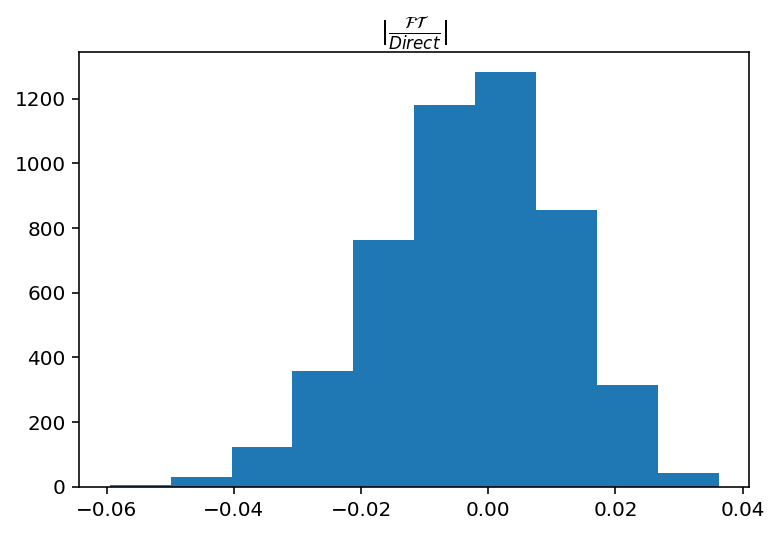

In [1312]:
plt.title(r"$\left|\frac{\mathcal{FT}}{Direct}\right|$");
plt.hist(np.log10(np.abs(ftdata/sd)))

### Playground

In [1166]:
sd0, sd0f = bad_data([points[0]], Nside, M, dlen)
sd1, sd1f  = bad_data([points[1]], Nside, M, dlen)
sd2, sd2f  = bad_data([points[2]], Nside, M, dlen)
sdtot, sdtf = bad_data(points, Nside, M, dlen)

In [1151]:
# sd0, _ =  get_data([points[0]], phase_correction, beam_suppress, beam_comp_phase, gpos, fake_conv)
# sd1, _ =  get_data([points[1]], phase_correction, beam_suppress, beam_comp_phase, gpos, fake_conv)
# sd2, _ =  get_data([points[2]], phase_correction, beam_suppress, beam_comp_phase, gpos, fake_conv)
# sdtot, _ = get_data(points, phase_correction, beam_suppress, beam_comp_phase, gpos, fake_conv)

In [1169]:
sdtot - (sd0 + sd1 + sd2)

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [1170]:
sdtot/ftotal

array([1.+5.52084551e-13j, 1.+3.34735135e-14j, 1.-9.72812814e-13j, ...,
       1.+5.52084551e-13j, 1.+3.34735135e-14j, 1.+5.52084551e-13j])

In [1113]:
fdats = []
fgrids = []
for p in points:
    rgrid = make_realgrid([p], brad=0, Nside=Nside, M=M)
    ftgrid = np.fft.fft2(rgrid)
    fgrids.append(ftgrid)
    ftdata = get_ftdata(ftgrid, beams, npoints)
    fdats.append(ftdata)

In [1115]:
rgrid = make_realgrid(points, brad=0, Nside=Nside, M=M)
ftgrid = np.fft.fft2(rgrid)
ftotal = get_ftdata(ftgrid, beams, npoints)

In [1156]:
ftotal - (fdats[0] + fdats[1] + fdats[2])

array([-1.02193809e-11+6.92779167e-12j, -2.13304929e-11-2.21866969e-11j,
        2.21049845e-11-3.10116377e-11j, ...,
       -1.02193809e-11+6.92779167e-12j, -2.13304929e-11-2.21866969e-11j,
       -1.02193809e-11+6.92779167e-12j])

In [1157]:
np.abs(sd2/fdats[2])

array([8.32185008e-09, 8.32185008e-09, 8.32185008e-09, ...,
       8.32185008e-09, 8.32185008e-09, 8.32185008e-09])

(array([  49.,  114.,  606.,  892.,  753., 1225.,  662.,  276.,  275.,
          98.]),
 array([5.05280733e-11, 5.05280733e-11, 5.05280733e-11, 5.05280733e-11,
        5.05280733e-11, 5.05280733e-11, 5.05280733e-11, 5.05280733e-11,
        5.05280733e-11, 5.05280733e-11, 5.05280733e-11]),
 <a list of 10 Patch objects>)

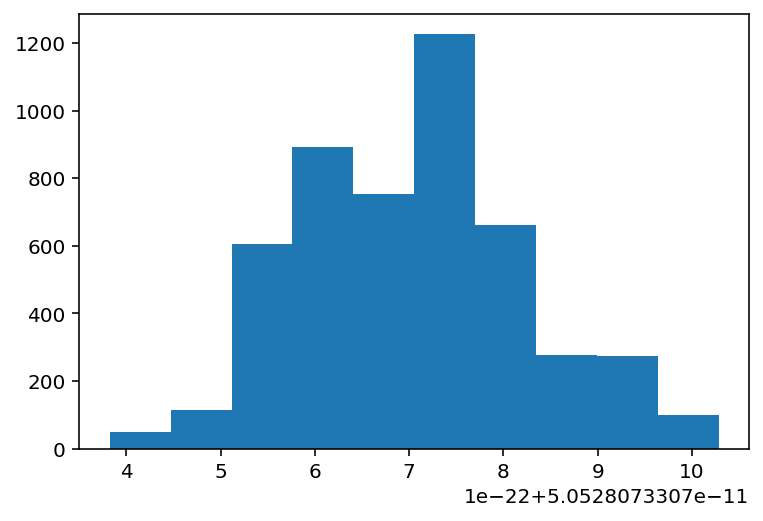

In [1158]:
plt.hist(np.abs(sd0/fdats[0]).flatten())

In [1159]:
sumtgrid = fgrids[0] + fgrids[1] + fgrids[2]
np.max(ftgrid - sumtgrid)

(2.220446049250313e-15+4.440892098500626e-16j)

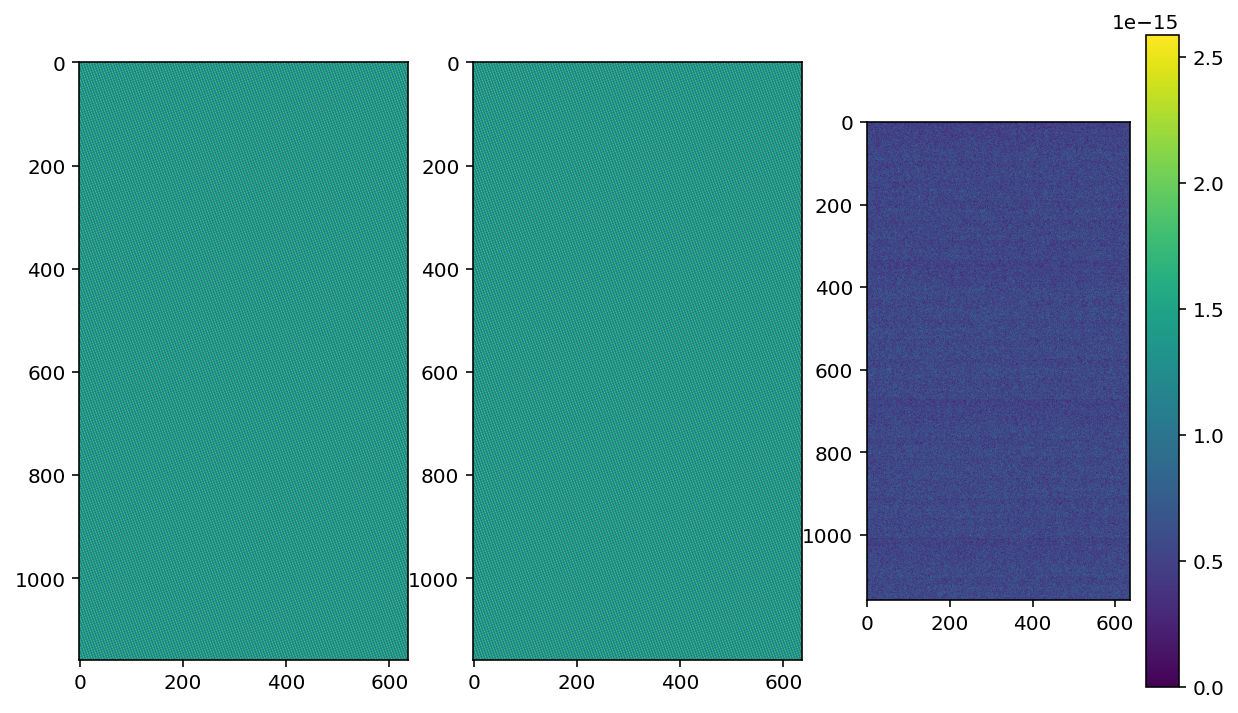

In [1118]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
ax[0].imshow(np.abs(sumtgrid))
ax[1].imshow(np.abs(ftgrid))
im = ax[2].imshow(np.abs(ftgrid - sumtgrid))
plt.colorbar(im);

In [1055]:
def bad_data(points, Nside, M, dlen):
    Mfac = 2*M + 1
    N_x, N_y = get_new_shape(Nside, M)
    visibs = np.zeros(dlen, dtype=np.complex128)
    n = 0
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside, Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside, Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            baseline = np.array(baseline)
            errored_baseline = Mfac * (baseline + (gpos[j] - gpos[i]))
            for p in points:
                px, py = np.floor(p[0]*N_x)/N_x, np.floor(p[1]*N_y)/N_y
                newp = np.array([px, py])
                visibs[n] += np.exp(-2j*np.pi*(np.dot(errored_baseline, newp)))
            n += 1
    return visibs

In [963]:
npoints = 3
points = np.random.uniform(size=(npoints,2))
rgrid = make_realgrid(points, brad=0, Nside=Nside, M=M)
ftgrid = np.fft.fft2(rgrid)

In [964]:
N_x, N_y = get_new_shape(Nside, M)
p = points[0]

In [965]:
kale = np.mgrid[0:N_x, 0:N_y]
lettuce = np.zeros_like(kale[0], dtype=np.complex128)
for x, y in zip(kale[0].flatten(), kale[1].flatten()):
    for p in points:
        px, py = np.floor(p[0]*N_x)/N_x, np.floor(p[1]*N_y)/N_y
        xy = np.array([x, y])
        fake_offset = xy
        tup_fake = tuple(fake_offset)
        lettuce[tup_fake] += np.exp(-2*np.pi*1j*(x*px + y*py))

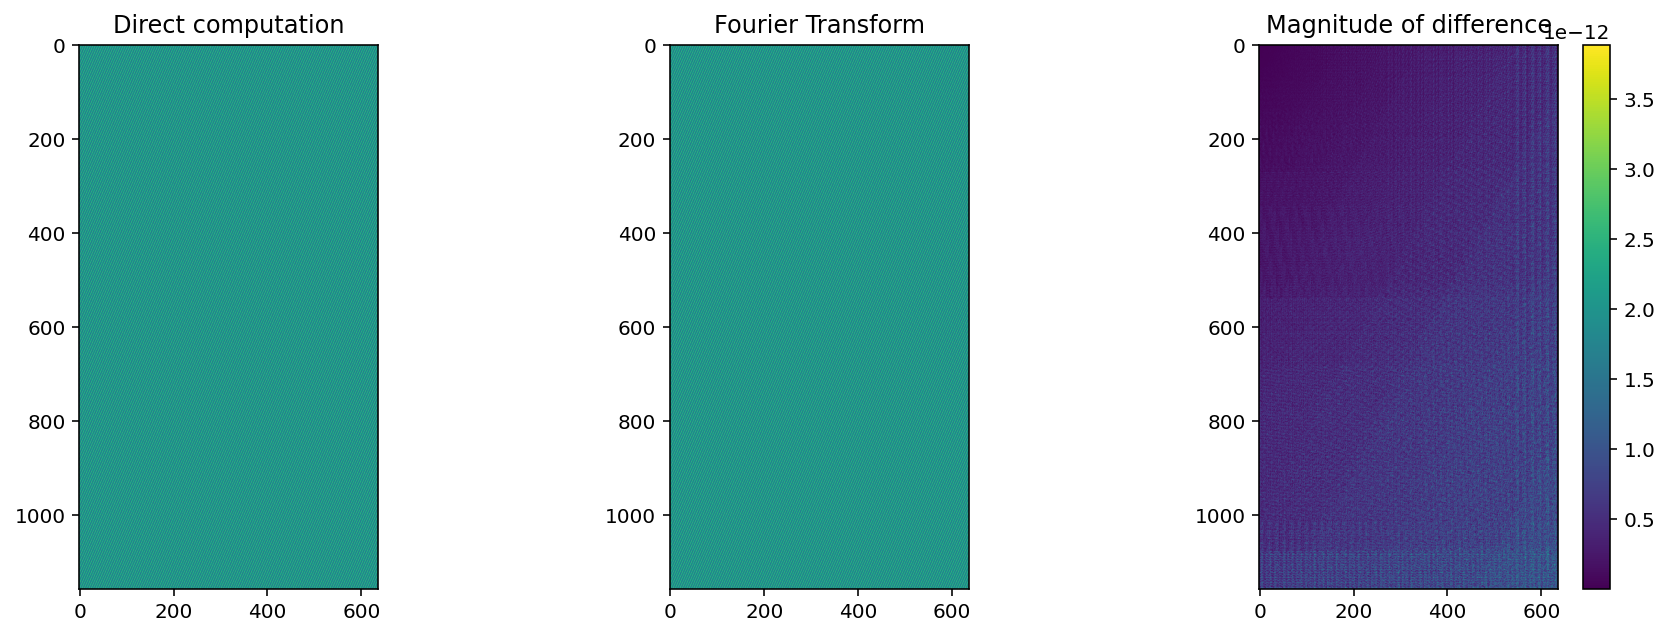

In [966]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(np.abs(lettuce))
ax[0].set_title("Direct computation")
ax[1].imshow(np.abs(ftgrid));
ax[1].set_title("Fourier Transform")
im = ax[2].imshow(np.abs(lettuce - ftgrid))
ax[2].set_title("Magnitude of difference")
fig.colorbar(im);

In [687]:
invlettuce = np.fft.ifft2(lettuce)
invft = np.fft.ifft2(ftgrid)

In [688]:
print("Lettuce: ", np.argmax(np.abs(invlettuce)), np.max(np.abs(invlettuce)))
print("FT: ", np.argmax(np.abs(invft)), np.max(np.abs(invft)))

Lettuce:  175945 1.0
FT:  645706 0.9999999999999999


In [689]:
print("FT point: ", np.where(np.abs(invft - 1) < 1e-1))
print("Lettuce point: ", np.where(np.abs(invlettuce - 1) < 1e-1))
print("Truth point: ", np.where(rgrid == 1))

FT point:  (array([ 276,  683, 1015]), array([408, 261, 166]))
Lettuce point:  (array([ 276,  684, 1016]), array([409, 261, 166]))
Truth point:  (array([ 276,  683, 1015]), array([408, 261, 166]))


Text(0.5, 1.0, 'FT IFFT')

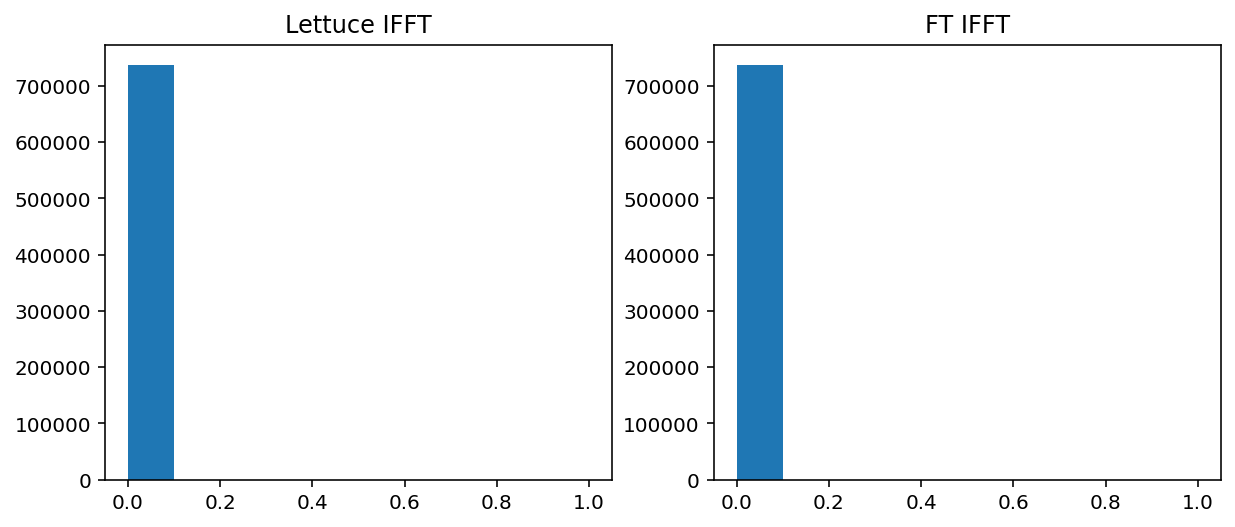

In [690]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(np.abs(invlettuce).flatten())
ax[0].set_title("Lettuce IFFT")

ax[1].hist(np.abs(invft).flatten())
ax[1].set_title("FT IFFT")

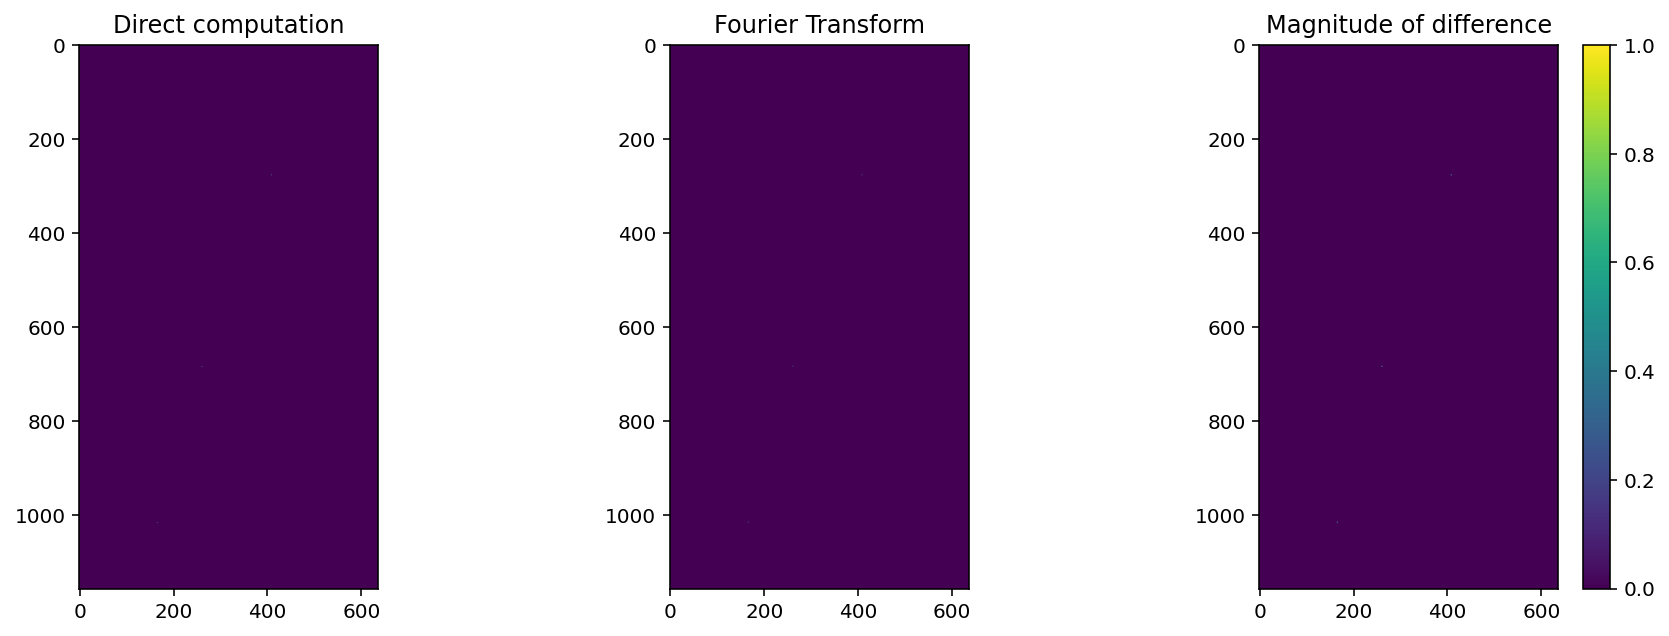

In [691]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(np.abs(invlettuce))
ax[0].set_title("Direct computation")
ax[1].imshow(np.abs(invft));
ax[1].set_title("Fourier Transform")
im = ax[2].imshow(np.abs(invlettuce -  invft))
ax[2].set_title("Magnitude of difference")
fig.colorbar(im);